<a href="https://colab.research.google.com/github/talhaanwarch/skin_cancer_detection_phone_camera/blob/master/SCENARIO_IV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Scenario II:** Training on ISIC 2019 and tested on PAD dataset (Only images)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!cp /content/drive/My\ Drive/isic_weights/isicall_eff3_weights.hdf5 /content/

In [4]:
%%capture
!pip install efficientnet
!pip install pytorch-tabnet

In [5]:
#download the dataset
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/zr7vgbcyr2-1.zip

--2020-08-27 09:16:40--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/zr7vgbcyr2-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.65.91
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.65.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3593344681 (3.3G) [application/octet-stream]
Saving to: ‘zr7vgbcyr2-1.zip’

zr7vgbcyr2-1.zip    100%[===================>]   3.35G  11.0MB/s    in 5m 26s  

2020-08-27 09:22:07 (10.5 MB/s) - ‘zr7vgbcyr2-1.zip’ saved [3593344681/3593344681]



In [6]:
#unzip the dataset
%%capture
!unzip zr7vgbcyr2-1.zip

In [7]:
#create a new folder named as data
!mkdir data

In [8]:
#unzip all subfolder
%%capture
!unzip /content/images/imgs_part_1.zip
!unzip /content/images/imgs_part_2.zip
!unzip /content/images/imgs_part_3.zip

In [9]:
#move all pictures from subfolder to main folder data
!mv  /content/imgs_part_1/* /content/data
!mv  /content/imgs_part_2/* /content/data
!mv  /content/imgs_part_3/* /content/data

In [10]:
#remove the folder that contain subfolders
!rm -r /content/images

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,StratifiedKFold
import gc

from sklearn.metrics import classification_report,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score
#read annotation file
df=pd.read_csv('/content/metadata.csv')
df.head()

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,fitspatrick,region,diameter_1,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,PAT_1516,1765,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARM,NaN,NaN,NEV,False,False,False,False,False,False,PAT_1516_1765_530.png,False
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,True,True,3.0,NECK,6.0,5.0,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True
2,PAT_1545,1867,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FACE,NaN,NaN,ACK,True,False,False,False,False,False,PAT_1545_1867_547.png,False
3,PAT_1989,4061,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAND,NaN,NaN,ACK,True,False,False,False,False,False,PAT_1989_4061_934.png,False
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,False,False,False,1.0,FOREARM,5.0,5.0,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True


In [36]:
labels=pd.get_dummies(df['diagnostic'])
df_img=pd.concat([df['img_id'],labels],axis=1)
df_img.head()

,img_id,ACK,BCC,MEL,NEV,SCC,SEK
0,PAT_1516_1765_530.png,0,0,0,1,0,0
1,PAT_46_881_939.png,0,1,0,0,0,0
2,PAT_1545_1867_547.png,1,0,0,0,0,0
3,PAT_1989_4061_934.png,1,0,0,0,0,0
4,PAT_684_1302_588.png,0,1,0,0,0,0


In [38]:
df['skin_cancer_history']=df['skin_cancer_history'].fillna('unknown').astype('str')
df['cancer_history']=df['cancer_history'].fillna('unknown').astype('str')

In [39]:
df['diameter_1'].fillna(df['diameter_1'].mean(),inplace=True)
df['diameter_2'].fillna(df['diameter_2'].mean(),inplace=True)

In [40]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
encLE=LabelEncoder()
encOHE=OneHotEncoder(sparse=False)

In [41]:
for i in df.columns[2::]:
  if i!='diagnostic' or i!='img_id':
    df[i]=encLE.fit_transform(df[i].astype('str'))

In [42]:
df.head()

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,fitspatrick,region,diameter_1,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,PAT_1516,1765,2,2,13,11,68,2,2,2,2,2,2,6,1,6,37,3,0,0,0,0,0,0,456,0
1,PAT_46,881,0,0,9,7,42,0,0,1,1,1,1,2,10,35,31,1,1,1,0,1,1,1,1446,1
2,PAT_1545,1867,2,2,13,11,65,2,2,2,2,2,2,6,5,6,37,0,1,0,0,0,0,0,478,0
3,PAT_1989,4061,2,2,13,11,63,2,2,2,2,2,2,6,8,6,37,0,1,0,0,0,0,0,845,0
4,PAT_684,1302,0,1,9,7,67,0,1,1,0,0,0,0,7,33,31,1,1,1,0,0,1,1,1770,1


In [94]:
tab_features=df.drop(['patient_id','lesion_id','diagnostic','img_id'],axis=1)
tab_labels=df['diagnostic']
tab_features.head()

,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,fitspatrick,region,diameter_1,diameter_2,itch,grew,hurt,changed,bleed,elevation,biopsed
0,2,2,13,11,68,2,2,2,2,2,2,6,1,6,37,0,0,0,0,0,0,0
1,0,0,9,7,42,0,0,1,1,1,1,2,10,35,31,1,1,0,1,1,1,1
2,2,2,13,11,65,2,2,2,2,2,2,6,5,6,37,1,0,0,0,0,0,0
3,2,2,13,11,63,2,2,2,2,2,2,6,8,6,37,1,0,0,0,0,0,0
4,0,1,9,7,67,0,1,1,0,0,0,0,7,33,31,1,1,0,0,1,1,1


In [104]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'learning_rate':[0.1,0.2,0.5,0.01,0.0001,0.005]
        }

xgb = XGBClassifier(learning_rate=0.02, n_estimators=1000, objective='multi:softprob',
                    silent=True, nthread=1)

In [105]:
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=5, scoring='f1_macro', n_jobs=-1, cv=KFold(5).split(tab_features,tab_labels), verbose=3, random_state=1001 )

In [97]:
random_search.fit(tab_features,tab_labels)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.9min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f338a7bdfc0>,
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.02, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=1000,
                                           n_jobs=1, nthread=1,
                                           objective='multi:softpr...
                                           verbosity=1),
                   iid='deprecated', n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.

In [98]:
print(random_search.best_score_)
print(random_search.best_estimator_)

0.7283370750670046
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1,
              learning_rate=0.5, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1.0, verbosity=1)


In [110]:
xgb_clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1,
              learning_rate=0.5, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1.0, verbosity=1)

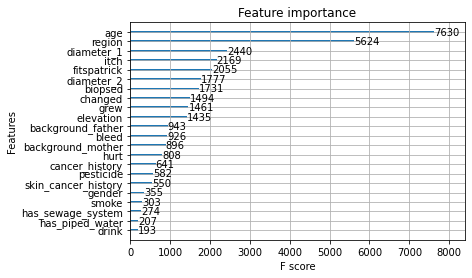

In [101]:
from xgboost import plot_importance
plot_importance(xgb)

In [108]:
# tab_cols=['age', 'fitspatrick', 'region','diameter_1', 'diameter_2', 'itch', 'grew', 'changed','elevation', 'biopsed']
# random_search.fit(tab_features[tab_cols],tab_labels)


In [111]:
#labels columns in dataframe
col=list(df_img.columns)[-6::]
col

['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK']

In [112]:
# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen= ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    rescale=1/255,
    fill_mode='nearest')

In [113]:
# model hyperparameters
img_shape=300
batch_size=20
n_epochs=20

In [114]:
from tensorflow.keras.layers import GlobalAveragePooling2D,Dropout,Dense
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential,Model

In [115]:
#first create the pretrained model and load weights


In [119]:
def basemodel():
  import efficientnet.tfkeras as efn
  pre_trained_model =efn.EfficientNetB3(weights =None, include_top=False, input_shape = (img_shape,img_shape,3))
  x = pre_trained_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation="relu")(x)
  x = Dropout(0.3)(x)
  x = Dense(64, activation="relu")(x)
  predictions = Dense(8, activation="softmax")(x) #pretrained model has 7 classes
  pre_trained_model = Model(inputs=pre_trained_model.input, outputs=predictions)
  pre_trained_model.load_weights('/content/isicall_eff3_weights.hdf5') #load pretrained weights to to model
  #now remove all added layers in pretrained layers add new leayer and create base model
  #here we can test how many layers we want to remove
  base_model = Model(pre_trained_model.input, pre_trained_model.layers[-7].output)
  #now add our new layers
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.3)(x)
  x = Dense(128,name='dense1', activation="relu")(x)
  x = Dropout(0.3)(x)
  x = Dense(64,name='dense2', activation="relu")(x)

  predictions  = Dense(len(col),name='output', activation="softmax")(x) #base model has six layers
  base_model = Model(inputs=base_model.input, outputs=predictions )
  #compile the base model
  base_model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return base_model

In [ ]:


classification_reports=[]
kf = KFold(n_splits=5,shuffle=True)
history=[]
accuracy=[]
f1_scores=[]
recall=[]
precision=[]
auc=[]
y_pred=[]
fold=0
for train_index, test_index in kf.split(df):
  train=df_img.iloc[train_index,:]
  val=df_img.iloc[test_index,:]
  print('-----------fold {}--------------'.format(fold))
  train_generator=data_gen.flow_from_dataframe(train,directory='/content/data',
                                               target_size=(img_shape,img_shape),
                                               x_col='img_id',
                                               y_col=col,
                                               class_mode='raw',
                                               shuffle=False,
                                               batch_size=batch_size)

  val_generator=data_gen.flow_from_dataframe(val,directory='/content/data',
                                             target_size=(img_shape,img_shape),
                                             x_col="img_id",
                                             y_col=col,
                                             class_mode='raw',
                                             shuffle=False,
                                             batch_size=batch_size)
  #train_generator.next()[0].shape,train_generator.next()[1].shape

  #load base model
  base_model=basemodel()
  #train model
  results = base_model.fit(train_generator,epochs=25,verbose=1,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=val_generator,
                             validation_steps=val_generator.n/batch_size,
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=3, min_lr=0.000001),
                                         #ModelCheckpoint('model_{}.hdf5'.format(fold), save_best_only=True, monitor='val_loss', mode='min')
                                         ])
  #model.load_weights('model_{}.hdf5'.format(fold))

  xgb_clf.fit(tab_features.values[train_index,:],tab_labels.iloc[train_index],verbose=False)
  cat_pred=cat_model.predict_proba(tab_features.values[test_index,:])
  val_generator.reset()
  img_pred=base_model.predict(val_generator,steps=val_generator.n/batch_size,verbose=0)

  y_true=val.iloc[:,-6::]
  f1_img=f1_score(y_true,img_pred,average='macro')
  f1_tab=f1_score(y_true,cat_pred,average='macro')

  break
  y_pred=np.mean([img_pred,cat_pred],axis=0)


  

  f1=f1_score(y_true,y_pred,average='macro',labels=np.unique(y_pred))
  print('f1 score is ', f1)

  accuracy.append(accuracy_score(y_true,y_pred))
  auc.append(roc_auc_score(y_true,y_pred))
  precision.append(precision_score(y_true,y_pred,average='macro'))
  recall.append(recall_score(y_true,y_pred,average='macro'))
  f1_scores.append(f1)
  history.append(results)
  fold+=1

  del base_model
  K.clear_session()
  gc.collect()


-----------fold 0--------------
Found 1838 validated image filenames.
Found 460 validated image filenames.
Epoch 1/25
92/91 [==============================] - 175s 2s/step - loss: 1.2183 - accuracy: 0.5582 - val_loss: 1.3466 - val_accuracy: 0.5978
Epoch 2/25
92/91 [==============================] - 172s 2s/step - loss: 0.8981 - accuracy: 0.6785 - val_loss: 0.8543 - val_accuracy: 0.7174
Epoch 3/25
92/91 [==============================] - 171s 2s/step - loss: 0.7528 - accuracy: 0.7345 - val_loss: 1.0933 - val_accuracy: 0.6587
Epoch 4/25
92/91 [==============================] - 172s 2s/step - loss: 0.6971 - accuracy: 0.7388 - val_loss: 1.0612 - val_accuracy: 0.6435
Epoch 5/25
92/91 [==============================] - 172s 2s/step - loss: 0.6355 - accuracy: 0.7655 - val_loss: 0.9666 - val_accuracy: 0.6413
Epoch 6/25
92/91 [==============================] - 172s 2s/step - loss: 0.5176 - accuracy: 0.8063 - val_loss: 0.8847 - val_accuracy: 0.7130
Epoch 7/25
92/91 [=============================

In [134]:
img_pred=base_model.predict(val_generator,steps=val_generator.n/batch_size,verbose=0)
y_true=val.iloc[:,-6::]
f1_img=f1_score(y_true,np.round(img_pred,0),average='macro')
f1_tab=f1_score(y_true,np.round(cat_pred,0),average='macro')
f1_img,f1_tab

(0.47839529670246356, 0.7403379614102709)

In [135]:
f1b=f1_img+f1_tab

In [151]:
np.round(img_pred,0)

array([[0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [152]:
np.round(cat_pred,0)

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [150]:
y_pred=np.mean([np.round(img_pred,0)/f1b*f1_img,np.round(cat_pred,0)/f1b*f1_tab],axis=0)
np.round(y_pred,0)

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# print classification report of all folds
for report in classification_reports:
  print('--------------------------------------------------------')
  print(report)

In [ ]:
#average accuracy across all folds
np.mean(accuracy)

0.6745221180259543

In [ ]:
#average f1_scores across all folds
np.mean(f1_scores)

0.8426479132214546

In [ ]:
#average auc_scores across all folds
np.mean(auc)

0.723057369732368

In [ ]:
history[0].history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [ ]:
def plot_accuracy(hist,acc='val_accuracy'):
    for i in range(5):
      plt.plot(hist[i].history[acc],linestyle='-.',linewidth=1.5)
     
    mean=np.mean([[j for j in x.history[acc]] for x in hist],axis=0)
    std=np.std([[j for j in x.history[acc]] for x in hist],axis=0)
    plt.plot(mean,linewidth=2,color='black')
    if acc=='val_accuracy':
      plt.title('Model Validation Accuracy')
    else:
      plt.title('Model Training Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Fold1','Fold2','Fold3','Fold4','Fold5','Average Val Accuracy' ], loc='best')
    plt.show()

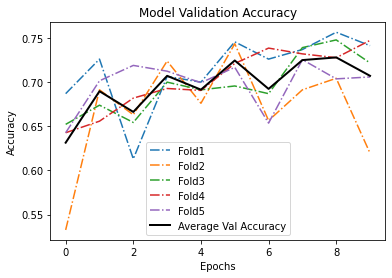

In [ ]:
plot_accuracy(history)

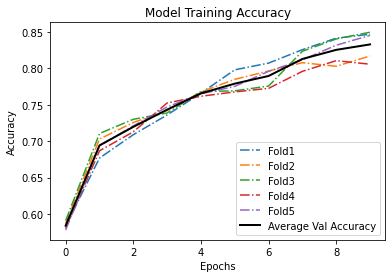

In [ ]:
plot_accuracy(history,acc='accuracy')